# Background regions `ntag_pag`

**Motivation:** Alessandra asked us a question in the HHComb meeting about how often we selected the 4bs in data, and it seemed like we could get some nice background rejection using `ntag_pag` instead of `ntag` (in terms of yields), but here I want to test this out with some of my newer trainings :)

In [1]:
import dask.dataframe as dd
import pyarrow.parquet as pq
import pyarrow as pa

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from analysis import getXhh
from utils import mcToYr

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

Welcome to JupyROOT 6.22/00
Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
physicsSample = 'data17'
prodTag = 'JUN20'
nSelectedJets = 5

In [3]:
cols = ['m_hh','ntag','m_h1','m_h2','kinematic_region','X_wt','Xhh',
        'j3_Db','Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2']

Ok - so I think I'll want to load in a bounding box that's generous enough to include some optimization for the ... as well, so let's calculate what those are right here.

In [4]:
print(120 * 1.05 - 45,  120 * 1.05 + 45,110 * 1.05 - 45,  110 * 1.05 + 45)

81.0 171.0 70.5 160.5


In [5]:
print(125 * 1.01 - 45,  125 * 1.01 + 45,116 * 1.01 - 45,  116 * 1.01 + 45)

81.25 171.25 72.16 162.16


In [6]:
print(125 * 1.01 - 45,  125 * 1.01 + 45,113.5 * 1.01 - 45,  113.5 * 1.01 + 45)

81.25 171.25 69.635 159.635


In [7]:
m1_min, m1_max = 80, 172
m2_min, m2_max = 69, 163

In [8]:
%%bash

ls ../data/data17-JUN20_2b1jBucketBug/files

cutflow_min_dR1_2b_Db_sort_periodB_000001.h5
cutflow_min_dR1_2b_Db_sort_periodB_000002.h5
cutflow_min_dR1_2b_Db_sort_periodB_000003.h5
cutflow_min_dR1_2b_Db_sort_periodB_000004.h5
cutflow_min_dR1_2b_Db_sort_periodB_000005.h5
cutflow_min_dR1_2b_Db_sort_periodB_000006.h5
cutflow_min_dR1_2b_Db_sort_periodB_000007.h5
cutflow_min_dR1_2b_Db_sort_periodB_000008.h5
cutflow_min_dR1_2b_Db_sort_periodB_000009.h5
cutflow_min_dR1_2b_Db_sort_periodB_000010.h5
cutflow_min_dR1_2b_Db_sort_periodB_000011.h5
cutflow_min_dR1_2b_Db_sort_periodB_000012.h5
cutflow_min_dR1_2b_Db_sort_periodB_000013.h5
cutflow_min_dR1_2b_Db_sort_periodB_000014.h5
cutflow_min_dR1_2b_Db_sort_periodB_000015.h5
cutflow_min_dR1_2b_Db_sort_periodB_000016.h5
cutflow_min_dR1_2b_Db_sort_periodB_000017.h5
cutflow_min_dR1_2b_Db_sort_periodB_000019.h5
cutflow_min_dR1_2b_Db_sort_periodB_000020.h5
cutflow_min_dR1_2b_Db_sort_periodB_000021.h5
cutflow_min_dR1_2b_Db_sort_periodB_000022.h5
cutflow_min_dR1_2b_Db_sort_periodB_000023.h5
cutflow_mi

In [9]:
dat_dR1 = dd.read_parquet(f'../data/data17-JUN20_2b1jBucketBug/files/df_min_dR1_?b_Db_sort_period?_00*.parquet',
                          columns=cols+['abs_deta_hh'])

dR1 = dat_dR1.loc[(dat_dR1.abs_deta_hh < 1.5) & (dat_dR1.m_h1 > m1_min) & (dat_dR1.m_h1 < m1_max) \
                  & (dat_dR1.m_h2 > m2_min) & (dat_dR1.m_h2 < m2_max),cols].compute()



/u/ki/nhartman/.local/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [10]:
dat_pag_Db = dd.read_parquet(f'../data/data17-JUN20-5jets_2b1jBucketBug/files/df_preLN_lr_0p003_?b_Db_sort_period?_00*.parquet',
                          columns=cols+['abs_deta_hh','ntag_pag'])
 
pag_Db = dat_pag_Db.loc[(dat_pag_Db.abs_deta_hh < 1.5) & \
                        (dat_pag_Db.m_h1 > m1_min) & (dat_pag_Db.m_h1 < m1_max) & \
                        (dat_pag_Db.m_h2 > m2_min) & (dat_pag_Db.m_h2 < m2_max),
                        cols+['ntag_pag']].compute()

In [11]:
dat_pag_btag = dd.read_parquet(f'../data/data17-JUN20-5jets_2b1jBucketBug/files/df_btag_5j_?b_Db_sort_period?_00*.parquet',
                               columns=cols+['abs_deta_hh','ntag_pag'])

pag_btag = dat_pag_btag.loc[(dat_pag_btag.abs_deta_hh < 1.5) & \
                            (dat_pag_btag.m_h1 > m1_min) & (dat_pag_btag.m_h1 < m1_max) & \
                            (dat_pag_btag.m_h2 > m2_min) & (dat_pag_btag.m_h2 < m2_max),
                            cols+['ntag_pag']].compute()

In [12]:
psymb = '$\mathrm{\mathbb{P}}$'

In [13]:
preXwt = "$\mathbf{ATLAS}$ Simulation Internal\n"
preXwt += f"data17, {prodTag} MNT prod\n"
preXwt += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5"

In [14]:
figDir = f'figures/data17-JUN20/preLN_lr_0p003/'

In [15]:
import logging
     
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

CR
  $D_b$ 0.8116872692245947
  $b$-tag 0.8193968098426697
VR
  $D_b$ 0.8010304810516685
  $b$-tag 0.8171225683852578


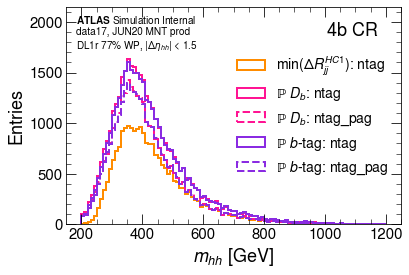

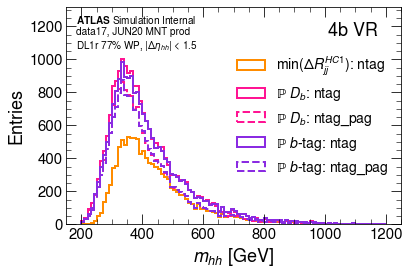

In [16]:
nb = 100
r = (200,1200)

for k,region in zip([2,1],['CR','VR']):
    
    plt.figure()
    plt.hist(dR1.loc[(dR1.ntag >= 4) & (dR1.kinematic_region==k),'m_hh'],nb,r,histtype='step',lw=2,
             label='$\min(\Delta R_{jj}^{HC1})$: ntag',color='darkorange')
    
    print(region)
    
    for pag,color,feature in zip([pag_Db,pag_btag],['deeppink','blueviolet'],['$D_b$','$b$-tag']):
        plt.hist(pag.loc[(pag.ntag >= 4) & (pag.kinematic_region==k),'m_hh'],
                 nb,r,histtype='step',lw=2,
                 label=f'{psymb} {feature}: ntag',color=color)

        plt.hist(pag.loc[(pag.ntag_pag >= 4) & (pag.kinematic_region==k),'m_hh'],
                 nb,r,histtype='step',lw=2,ls='--',
                 label=f'{psymb} {feature}: ntag_pag',color=color)
        
        num = np.sum((pag.ntag_pag >= 4) & (pag.kinematic_region==k))
        den = np.sum((pag.ntag >= 4) & (pag.kinematic_region==k))
        print(' ',feature,num / den)
        
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=14,loc='center right')
    
    ax = plt.gca()
    plt.text(0.03,0.97,preXwt,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    plt.text(.93,.93,f'4b {region}',transform=ax.transAxes,ha='right',va='top',fontsize=18)
    
    _,ymax = plt.ylim()
    plt.ylim(0,1.25*ymax)
    
    plt.savefig(f'{figDir}/m_hh_4b_{region}_ntag_vs_ntag_pag.pdf',bbox_inches='tight')
    

CR
  $D_b$ 0.8067251340454715
  $b$-tag 0.8097849008857022
VR
  $D_b$ 0.7994638846627544
  $b$-tag 0.8101444957545062


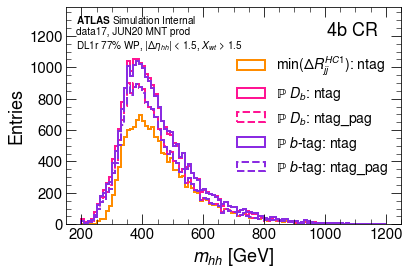

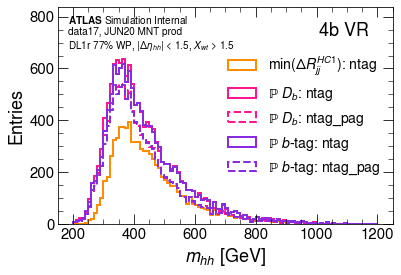

In [17]:
nb = 100
r = (200,1200)

for k,region in zip([2,1],['CR','VR']):
    
    plt.figure()
    plt.hist(dR1.loc[(dR1.ntag >= 4) & (dR1.kinematic_region==k) & (dR1.X_wt > 1.5),'m_hh'],
             nb,r,histtype='step',lw=2,
             label='$\min(\Delta R_{jj}^{HC1})$: ntag',color='darkorange')
    
    print(region)
    
    for pag,color,feature in zip([pag_Db,pag_btag],['deeppink','blueviolet'],['$D_b$','$b$-tag']):
        
        m = (pag.kinematic_region==k) & (pag.X_wt > 1.5)
        
        plt.hist(pag.loc[(pag.ntag >= 4) & m,'m_hh'],
                 nb,r,histtype='step',lw=2,
                 label=f'{psymb} {feature}: ntag',color=color)

        plt.hist(pag.loc[(pag.ntag_pag >= 4) & m,'m_hh'],
                 nb,r,histtype='step',lw=2,ls='--',
                 label=f'{psymb} {feature}: ntag_pag',color=color)
        
        num = np.sum((pag.ntag_pag >= 4) & m)
        den = np.sum((pag.ntag >= 4) & m)
        print(' ',feature,num / den)
        
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=14,loc='center right')
    
    ax = plt.gca()
    plt.text(0.03,0.97,preXwt+', $X_{wt}$ > 1.5',transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    plt.text(.93,.93,f'4b {region}',transform=ax.transAxes,ha='right',va='top',fontsize=18)
    
    _,ymax = plt.ylim()
    plt.ylim(0,1.25*ymax)
    
    plt.savefig(f'{figDir}/m_hh_4b_{region}_X_wt_ntag_vs_ntag_pag.pdf',bbox_inches='tight')
    

In [18]:
1/np.sqrt(.8)

1.118033988749895

This is awesome! If the signal stays *the same* then a $b$ reduction of 20% increases $s/\sqrt{b}$ by 1.12%. It's also particularly nice that the rejection power is *better* at higher mass.

**Next Q:** Can we start to get an idea of the $s / \sqrt{b}$ gains for pag vs $\min \Delta R$ by

Since I have the metrics above and did a quick check of the reweighting variables, I think it'll be ok.

In [19]:
figDir

'figures/data17-JUN20/preLN_lr_0p003/'

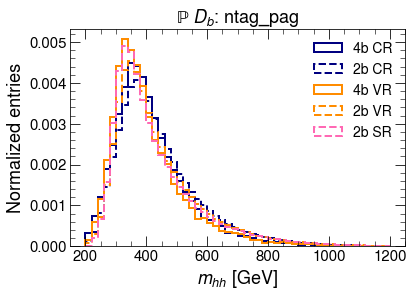

In [20]:
df = pag_Db

#fig, axes = plt.subplots

for k, region, c in zip([2,1,0],['CR','VR','SR'],['navy','darkorange','hotpink']):

    for ntag,ls in zip([4,2],['-','--']):

        if (k == 0) and (ntag == 4): continue
        
        m = (df.kinematic_region == k) & (df.ntag_pag == ntag)

        plt.hist(df.loc[m,'m_hh'],50,(200,1200),histtype='step',lw=2,color=c,ls=ls,
                 density=True,label=f'{ntag}b {region}')
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(fontsize=14)#,loc='center right')
plt.title(f'{psymb} $D_b$: ntag_pag')

plt.savefig(f'figures/data17-JUN20-5jets/preLN_lr_0p003/m_hh_2b_4b_ntag_pag_regions.pdf')
plt.show()

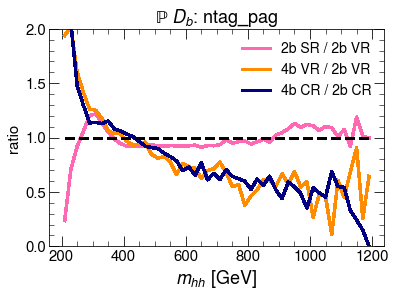

In [21]:
sr_2b,e = np.histogram(df.loc[(df.kinematic_region == 0) & (df.ntag_pag == 2),'m_hh'],
                       50,(200,1200), density=True)
vr_2b,_ = np.histogram(df.loc[(df.kinematic_region == 1) & (df.ntag_pag == 2),'m_hh'],
                       50,(200,1200), density=True)
cr_2b,_ = np.histogram(df.loc[(df.kinematic_region == 2) & (df.ntag_pag == 2),'m_hh'],
                       50,(200,1200),density=True)


vr_4b,_ = np.histogram(df.loc[(df.kinematic_region == 1) & (df.ntag_pag == 4),'m_hh'],
                       50,(200,1200),density=True)
cr_4b,_ = np.histogram(df.loc[(df.kinematic_region == 2) & (df.ntag_pag == 4),'m_hh'],
                       50,(200,1200),density=True)

xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx, sr_2b / vr_2b, 'hotpink',label='2b SR / 2b VR')
plt.plot(xx, vr_4b / vr_2b, 'darkorange',label='4b VR / 2b VR')
plt.plot(xx, cr_4b / cr_2b, 'navy',label='4b CR / 2b CR')
plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0,2)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio')
plt.title(f'{psymb} $D_b$: ntag_pag')
plt.legend()

plt.savefig(f'figures/data17-JUN20-5jets/preLN_lr_0p003/m_hh_ratio_options.pdf')


Interesting - it seems like the VR is a much better estimate of $m_{hh}$ than the 4b /2b mapping.


Ok - this is super interesting, but if what I'm trying to *estimate* is the efficacy of an altered SR, I'll need to make use of the 2b data.

I could *try* to derive an $m_{hh}$ reweighting function?

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Text(1.0, 1.0, '(4b CR / 2b CR)      ')

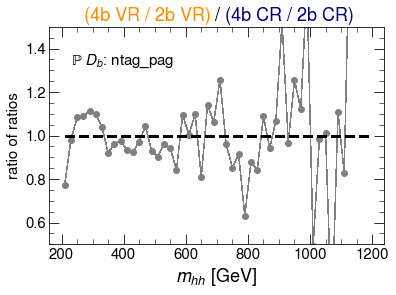

In [22]:
r_VR = vr_4b / vr_2b
r_CR = cr_4b / cr_2b

plt.plot(xx, r_VR / r_CR, 'grey',marker='o',lw=0.5)
plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0.5,1.5)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio of ratios')
plt.text(.05,.95,f'{psymb} $D_b$: ntag_pag',ha='left',va='top',transform=ax.transAxes)

plt.title('       (4b VR / 2b VR)',loc='left',color='darkorange')
plt.title('/')
plt.title('(4b CR / 2b CR)      ',loc='right',color='navy')


#plt.savefig(f'figures/data17-JUN20-5jets/preLN_lr_0p003/m_hh_r_VR_by_r_CR.pdf')


**Goal:** To get an idea of the difference in the SR definitions, let's

1. Take the 2b SR and *scale* it to the expected 4b yield using the CR
2. Multiply by r_CR to account for the anticipated *shift*

**Q:** Would the above background est get better if I used the updated CR / VR centers?

Let's try it out for `pag_Db` right here!!

In [ ]:
sdR = pd.read_parquet('../data/SMNR_mc16d-JUN20_2b1jBucketBug/df_min_dR1_3b_Db_sort.parquet',
                      columns=cols+['abs_deta_hh','mc_sf'])

In [ ]:
mc = 'mc16d'
nSelectedJets = 5

sp_Db   = pd.read_parquet(f'../data/SMNR_{mc}-{prodTag}-{nSelectedJets}jets_2b1jBucketBug/df_preLN_lr_0p003_3b_Db_sort.parquet',
                          columns=cols+['ntag_pag','abs_deta_hh','mc_sf'])
sp_btag = pd.read_parquet(f'../data/SMNR_{mc}-{prodTag}-{nSelectedJets}jets_2b1jBucketBug/df_btag_5j_3b_Db_sort.parquet',
                          columns=cols+['ntag_pag','abs_deta_hh','mc_sf'])

In [ ]:
x1, y1 = 125, 116

for dfi in [dR1,pag_Db,pag_btag, sdR, sp_Db, sp_btag]:
    dfi['Xhh_new'] = getXhh(dfi.m_h1,dfi.m_h2,x1,y1)

In [ ]:
cols

In [ ]:
nb, r = 50,(200,1200)

m = (df.kinematic_region==0) & (df.ntag_pag == 2)
n_SR = np.histogram(df.loc[m,'m_hh'],nb,r)[0]

new_SR = np.histogram(df.loc[(df.Xhh_new < 1.6) & (df.ntag_pag == 2),'m_hh'],nb,r)[0]

alpha = np.sum((df.kinematic_region==2) & (df.ntag_pag == 4)) / np.sum((df.kinematic_region==2) & (df.ntag_pag == 2))

plt.hist(xx,nb,r,histtype='step',color='deeppink',lw=2,label='bkg old SR',
         ls='--',weights=n_SR * alpha * r_CR)
plt.hist(xx,nb,r,histtype='step',color='mediumturquoise',lw=2,label='bkg new SR',
         ls='--',weights=new_SR * alpha * r_CR)

# Next: overlay the signals
smask = (sp_Db.ntag_pag ==4) & (sp_Db.abs_deta_hh < 1.5)

s_old,_,_ = plt.hist(sp_Db.loc[smask & (sp_Db.kinematic_region==0),'m_hh'],
                     nb,r,histtype='step',color='deeppink',lw=2,label='SM old SR',
                     weights=sp_Db.loc[smask & (sp_Db.kinematic_region==0),'mc_sf'])
s_new,_,_ = plt.hist(sp_Db.loc[smask & (sp_Db.Xhh_new<1.6),'m_hh'],
                     nb,r,histtype='step',color='mediumturquoise',lw=2,label='SM new SR',
                     weights=sp_Db.loc[smask & (sp_Db.Xhh_new<1.6),'mc_sf'])


plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries')
plt.title(f'{psymb} $D_b$: ntag_pag')
plt.legend()

ax = plt.gca()
#plt.text(.6,.4,'new SR center:\n. (125, 116) GeV',transform=ax.transAxes,ha='left',va='top')

plt.yscale('log')

plt.show()

'''
Look at s / sqrt(b)
'''
y_old = s_old / np.sqrt(n_SR   * alpha * r_CR)
y_new = s_new / np.sqrt(new_SR * alpha * r_CR)

plt.figure()
plt.plot(xx,y_old,color='deeppink',label='old SR')
plt.plot(xx,y_new,color='mediumturquoise',label='old SR')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('$s / \sqrt{b}$',fontsize=18)

plt.legend()

print('old',np.sqrt(np.sum(np.nan_to_num(y_old)**2)))
print('new',np.sqrt(np.sum(np.nan_to_num(y_new)**2)))

plt.plot()

Oh - gosh, I should *also* prob check that everything is still gucci w/ the $X_{wt}$ cut too, no??

In [ ]:
np.sqrt(np.sum(y_old[1:-1]**2)),np.sqrt(np.sum(y_new[1:-1]**2))

In [ ]:
0.17238378747276634 / 0.1633638401561219

Woah - if this 5% gain is *real*, this would be super exciting!!

Ok - sweet!! The point I *wanted* to make here was that $\mathrm{\mathbb{P}}$ had more room to grow than the other algos, so I think I should run through this suite of plots for the other 2 pairing algos that I have on the table right now.

In [ ]:
sr_2b,e = np.histogram(dR1.loc[(dR1.kinematic_region == 0) & (dR1.ntag == 2),'m_hh'],
                       50,(200,1200), density=True)
vr_2b,_ = np.histogram(dR1.loc[(dR1.kinematic_region == 1) & (dR1.ntag == 2),'m_hh'],
                       50,(200,1200), density=True)
cr_2b,_ = np.histogram(dR1.loc[(dR1.kinematic_region == 2) & (dR1.ntag == 2),'m_hh'],
                       50,(200,1200),density=True)


vr_4b,_ = np.histogram(dR1.loc[(dR1.kinematic_region == 1) & (dR1.ntag >= 4),'m_hh'],
                       50,(200,1200),density=True)
cr_4b,_ = np.histogram(dR1.loc[(dR1.kinematic_region == 2) & (dR1.ntag >= 4),'m_hh'],
                       50,(200,1200),density=True)

xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx, sr_2b / vr_2b, 'hotpink',label='2b SR / 2b VR')
plt.plot(xx, vr_4b / vr_2b, 'darkorange',label='4b VR / 2b VR')
plt.plot(xx, cr_4b / cr_2b, 'navy',label='4b CR / 2b CR')
plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0,2)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio')
plt.title('$\min \Delta R_{jj}^{HC1}$')
plt.legend()

plt.savefig(f'figures/data17-JUN20/min_dR1/m_hh_ratio_options.pdf')


In [ ]:
y = ( vr_4b / vr_2b ) / (cr_4b / cr_2b)

plt.plot(xx, y, 'grey',marker='o',lw=0.5)
plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0.5,1.5)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio of ratios')
plt.text(.2,.95,'min $\Delta R_{jj}^{HC1}$',ha='left',va='top',transform=ax.transAxes)

plt.title('       (4b VR / 2b VR)',loc='left',color='darkorange')
plt.title('/')
plt.title('(4b CR / 2b CR)      ',loc='right',color='navy')

plt.savefig(f'figures/data17-JUN20/min_dR1/m_hh_r_VR_by_r_CR.pdf')

In [ ]:
rw_CR = {'Db':r_CR,
         'dR1': cr_4b / cr_2b}

Yeah - so honestly I'm not as convinced about the efficacy of this background estimate for $\min \Delta R_{jj}^{HC1}$.

In [ ]:
nb, r = 50,(200,1200)

m = (dR1.kinematic_region==0) & (dR1.ntag == 2)
n_SR = np.histogram(dR1.loc[m,'m_hh'],nb,r)[0]

new_SR = np.histogram(dR1.loc[(dR1.Xhh_new < 1.6) & (dR1.ntag == 2),'m_hh'],nb,r)[0]

alpha = np.sum((dR1.kinematic_region==2) & (dR1.ntag >= 4)) / np.sum((dR1.kinematic_region==2) & (dR1.ntag == 2))

plt.hist(xx,nb,r,histtype='step',color='darkorange',lw=2,label='bkg old SR',
         ls='--',weights=n_SR * alpha * r_CR)
plt.hist(xx,nb,r,histtype='step',color='C3',lw=2,label='bkg new SR',
         ls='--',weights=new_SR * alpha * rw_CR['dR1'])

# Next: overlay the signals
smask = (sdR.ntag >=4) & (sdR.abs_deta_hh < 1.5)

s_old,_,_ = plt.hist(sdR.loc[smask & (sdR.kinematic_region==0),'m_hh'],
                     nb,r,histtype='step',color='darkorange',lw=2,label='SM old SR',
                     weights=sdR.loc[smask & (sdR.kinematic_region==0),'mc_sf'])
s_new,_,_ = plt.hist(sdR.loc[smask & (sdR.Xhh_new<1.6),'m_hh'],
                     nb,r,histtype='step',color='C3',lw=2,label='SM new SR',
                     weights=sdR.loc[smask & (sdR.Xhh_new<1.6),'mc_sf'])


plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries')
plt.title('min $\Delta R_{jj}^{HC1}$')
plt.legend()

ax = plt.gca()
#plt.text(.6,.4,'new SR center:\n. (125, 116) GeV',transform=ax.transAxes,ha='left',va='top')

plt.yscale('log')

plt.show()

'''
Look at s / sqrt(b)
'''
y_old = s_old / np.sqrt(n_SR   * alpha * rw_CR['dR1'])
y_new = s_new / np.sqrt(new_SR * alpha * rw_CR['dR1'])

plt.figure()
plt.plot(xx,y_old,color='darkorange',label='old SR')
plt.plot(xx,y_new,color='C3',label='new SR')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('$s / \sqrt{b}$',fontsize=18)
plt.title('min $\Delta R_{jj}^{HC1}$')

plt.legend()

print('old',np.sqrt(np.sum(np.nan_to_num(y_old[1:-1])**2)))
print('new',np.sqrt(np.sum(np.nan_to_num(y_new[1:-1])**2)))

plt.plot()

In [ ]:
0.1737810013000814/0.16574300246153786


Ok - now a little *less* than 5%, but the take away message is...

*these ideas for improving the limit are persisting across pairing algos*


**What about the performance as we vary the X_hh cut?**

In [ ]:
Xhhs = np.arange(1,2.1,.1)
Xhhs

In [ ]:
Xhhs = np.arange(1,2.1,.1)

z_dict = {}

for bdf,sdf,key,ntag in zip([pag_Db,dR1],[sp_Db,sdR],['Db','dR1'],['ntag_pag','ntag']):

    
    N_4b = np.sum((bdf.kinematic_region==2) & (bdf[ntag] >= 4))
    N_2b = np.sum((bdf.kinematic_region==2) & (bdf[ntag] == 2))

    smask = (sdf[ntag] >=4) & (sdf.abs_deta_hh < 1.5)
    
    z0 = []
    z1 = []
    
    for Xhh_cut in Xhhs:
    
        # Old
        n_SR = np.histogram(bdf.loc[(bdf.Xhh<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
        b = n_SR * (N_4b / N_2b) * rw_CR[key]
        
        s = np.histogram(sdf.loc[smask & (sdf.Xhh<Xhh_cut),'m_hh'],nb,r,
                         weights=sdf.loc[smask & (sdf.Xhh<Xhh_cut),'mc_sf'])[0]
        
        
        
        z = s / np.sqrt(b)
#         print(z)
        z0.append( np.sqrt(np.sum((z[1:-1])**2)) )
        
        # New
        new_SR = np.histogram(bdf.loc[(bdf.Xhh_new<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]

        b = new_SR * (N_4b / N_2b) * rw_CR[key]
        
        s = np.histogram(sdf.loc[smask & (sdf.Xhh_new<Xhh_cut),'m_hh'],nb,r,
                         weights=sdf.loc[smask & (sdf.Xhh_new<Xhh_cut),'mc_sf'])[0]
        
        z = np.nan_to_num(s / np.sqrt(b))
#         print(z)
        z1.append( np.sqrt(np.sum((z[1:-1])**2)) )
        
    z_dict[f'{key}0'] = z0
    z_dict[f'{key}1'] = z1

In [ ]:
figDir

In [ ]:
plt.plot(Xhhs,z_dict['Db0'],'deeppink',label=f'{psymb} Db: old SR')
plt.plot(Xhhs,z_dict['Db1'],'mediumturquoise',label=f'{psymb} Db: new SR',ls='--')
plt.plot(Xhhs,z_dict['dR10'],'darkorange',label=f'min dR1: old SR')
plt.plot(Xhhs,z_dict['dR11'],'C3',label=f'min dR1: new SR',ls='--')
 
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel('Quad sum significance')
plt.title('SM impact: pre $X_{wt}$')
plt.legend()

plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

Woah - ok, so going in *just a little bit* for the SR definition is helpful even! This is *new to me* lol.

At the very least, it does seem like a *new* SR definition can help us be more on a plateau.

*This is crazy that even still we have less of an improvement w/ pag than dR1 lol*.

(Later) **we can still try out the SR_in and SR_out splits**, but for now at least, I think this is helpful for some guesses for what's going on before we try out the rw.**

In [ ]:
df.Db_h1_j1.sum()

**New inside cateogry**

Would a 4b pure category help us at all??

In [ ]:
# df.loc[df.ntag_pag>=4,'Db_sum'] =  np.sum(df.loc[(df.ntag_pag>=4) & (df.kinematic_region==1),['Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2']].values,axis=1)